# Fast PDE/IE course, Skoltech, Spring 2015

## Problem (80 pts). High-Frequency Magnetic Resonance Imaging


Magnetic resonance imaging (MRI) is a non-invasive medical diagnostic technique, in which the atomic nuclei in the body are excited by a radio-frequency magnetic field.

In search of higher imaging resolutions, many research institutions are now developing MRI with high magnetic fields and resonant frequencies. For example, modern MRI systems built with $7$ Tesla superconducting magnets operate at $298.3$ MHz.

Understanding the effects that high-frequency MRI have on the human body begins with a model of the underlying physics. To demonstrate these principles, several simplifying assumptions and approximations are made that reduce the governing equations to the Helmholtz equation in non-conductive media:
$$
\Delta u({\bf r}) + k^2({\bf r}) u({\bf r}) = v({\bf r}) 
$$
where $u({\bf r})$ is the electric ﬁeld strength in volts per meter, $v({\bf r})$ is the electric excitation, $k({\bf r})$ is the wave
number, and ${\bf r} = (x,y,z)$ is the vector deﬁning the location of the observation point. 
Note that $k({\bf r})$ has the
following relationship with the other constants of electromagnetics:
$$
k^2({\bf r}) = \omega^2 \mu \epsilon({\bf r})
$$
where $\omega = 2\pi f$ is the angular frequency in radians per second, $\mu$ is the magnetic permeability in henries per
meter, and $\epsilon({\bf r})$ is the electric permittivity in farads per meter, as a function of the location vector ${\bf r}$.

Let us simulate the scattering of EM waves by the presence of a human head. Human tissue is slightly capacitive, but non-magnetic. We can model it as a material with magnetic permeability in the freespace $\mu = \mu_0 = 4\pi \cdot 10^{-7}$ H/m, and a location-dependent electric permittivity $\epsilon({\bf r}) = \epsilon_r \epsilon_0$. $u({\bf r})$ can be approximately chosen as zero on boundaries. 

Here is the $\epsilon_r$:

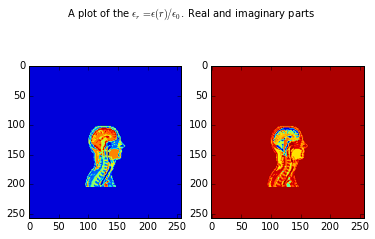

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
mat = scipy.io.loadmat('MRI_DATA.mat')
e_r = mat['e_r']
plt.subplot(1, 2, 1)
plt.imshow(np.real(e_r))
plt.subplot(1, 2, 2)
plt.imshow(np.imag(e_r))
plt.suptitle('A plot of the $\epsilon_r = \epsilon(r)/\epsilon_0$. Real and imaginary parts')

### An Integral Equation formulation
* (10 pts) Show that the Helmholtz equation can be represented in the integral equation formulation
$$
u({\bf r}) + \int \chi ({\bf r'}) u({\bf r'}) G({\bf r}-{\bf r'}) d{\bf r'} = 
\int v({\bf r'})G({\bf r}-{\bf r'}) d{\bf r'},
$$
where 
$$
G({\bf r}-{\bf r'}) = \frac{e^{ik_0\|{\bf r}-{\bf r'}\|}}{4\pi\|{\bf r}-{\bf r'}\|}
$$
is the Green’s function to the 3D Helmholtz operator and $\chi({\bf r}) = k^2({\bf r}) - k_0^2$, where $k^2_0 = \omega^2 \mu_0 \epsilon_0$. 
What kind of integral equation is this?
**Note:** if this task seems to be too challaging for you, skip it until the whole problem set will be solved


* (5 pts) Explain why the itegral formulation is more preferrable here as compared to the differential formulation

### Discretization
Let us consider system of linear equations obtained from a Galerkin discretization scheme of the integral formulation:
$$
A_h u_h = f_h
$$
where $u_h\in \mathbb{R}^{N\times 1}$ is the vector of unknowns, $f_h\in \mathbb{R}^{N\times 1}$ is the vector of excitations and $A_h\in \mathbb{R}^{N\times N}$ is the dense coupling coeﬃcient matrix.
To model the head, use the MRI data for $\epsilon_r ({\bf r}) = \epsilon ({\bf r})/\epsilon_0$
```MRI_DATA.mat```.

Consider the grid created by importing ``` MRI_DATA.mat```, which contains $N = 256^2$ ﬂat, square and
constant-value "pixels", with each side having a length $h = 1/256$ meters. Each pixel can be used as the
basis and testing functions in a Galerkin discretization.

* (5 pts) Write down an integral that can be used to evaluate $A_{ij}$, the element in the $i$-th row and $j$-th column of the coeﬃcient matrix $A$. Specify $A_{ij}$ where $\chi = 0$ (out of head regions). 

Let $f({\bf r})$ denote the excitation on the right-hand side:
$$
f({\bf r}) = \int v({\bf r'})G({\bf r}-{\bf r'}) d{\bf r'}.
$$
Let us set $v({\bf r})$ to an impulse (delta-function) located at $x = 0.6$ m and $y = 0.7$ m.

* (5 pts) How does $f({\bf r})$ look like in this case? Write down an integral that can be used to evaluate $f_i$, the element in the i-th row of the excitation matrix. 

It is worth mentioning the ease with which integral equations can handle impulses and singularities.

It is time to form a matrix. You are given two functions:

1. ```DEMCEM_ST``` (Athanasios G. Polimeridis, Direct Evaluation Method in Computational ElectroMagnetics http://web.mit.edu/thanos_p/www/DEMCEM.html). It calculates
$$
\text{DEMCEM_ST} = \int_0^h \int_0^h \int_0^h \int_0^h 
G\left(k, \sqrt{(x-x')^2 + (y - y')^2} \ \right) dx' dy' dx \, dy.
$$
```
k0 = 2*pi*f/299792458;
st = DEMCEM_ST(k0,h);
```

2. ```nwspgr```. It implements sparse grid quadrature, and was authored by Florian Heiss, Viktor Winschel at http://sparse-grids.de/. 
It generates multidimensional quadrature points via the sparse grid method. As the grid is really sparse, the calculations are done very fast. 

The ```nwspgr``` is a MATLAB function. Fortunately, you need fixed weights and quadrature points for all integrals. Demo code how to generate weights and nodes is shown below:

```
% 4-dimensional quadrature nodes and weights of order 3
[nodes, weights] = nwspgr('KPU', 4, 3); 
```
Given nodes and weights you can simply write in Python
```
% Quadrature for some 4-dimensional function "func"
integral = weights.dot(func(nodes[:, 1], nodes[:, 2],
                            nodes[:, 3], nodes[:, 4]))
```
to calculate a 4-dimensional integral of a function ```func```.

* (3 pt) Describe which matrix elements of $A$ can be computed via ```DEMCEM_ST```


* (12 pts) Using the coeﬃcients generated by ```DEMCEM_ST``` and ```nwspgr```, produce code that will compute any
element $A_{ij}$ in the coeﬃcient matrix $A$ for given $i$ and $j$. Measure the time it takes to ﬁll a single
column of the coeﬃcient matrix $A$. Notice that $A$ has a translation-invariant structure; estimate
the time it would take the ﬁll the entire matrix $A$ in case this structure goes unnoticed.

### A Fast Integral Equation Solver
Without noting the translation-invariant structure, forming the coeﬃcient matrix along requires the
evaluation of $N^2$ 4-dimensional integrals using quadrature. Then, invertion of the matrix directly with Gaussian elimination costs $\mathcal{O}(N^3)$.
Fortunately, a part of matrix $A$ has a block-Toeplitz structure that can be exploited to
solve the linear system using an iterative method with $\mathcal{O}(K_\text{iter}N \log N)$ complexity by embedding $A$ into a block-circulant matrix with circulant blocks.


* (10 pts) Check that $A= h^2  I + T  \text{diag}(\chi)$, where $T$  has block-Toeplitz with Toeplitz blocks structure. Describe the steps required to implement the matvec by $A$ using the FFT.


* (15 pts) Implement a fast matrix-vector (matvec) product function that will quickly evaluate the product $Ax$ for
a given $x$.


* (15 pts) Embed the matvec function from the bullet above into ```GMRES``` to 
solve the integral equation without explicitly forming the dense coupling matrix.  Solve the scattering problem using ```GMRES``` for $f = 21.3$ MHz and $f = 298.3$ MHz, corresponding
to the older $0.5$ T permanent magnet MRI and the modern $7$ T superconductor magnet MRI
respectively. Produce iteration-residual plots at both frequencies, and the scattered image. 

In [2]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()